# Ненадгледувано Учење

### Дабеска Мила 193263

&nbsp;

## Import the required libraries

In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from mpl_toolkits.mplot3d import Axes3D
from sklearn.mixture import GaussianMixture
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.decomposition import PCA
from sklearn.impute import SimpleImputer
import itertools
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.datasets import make_blobs
from scipy.spatial import distance
from sklearn.metrics import silhouette_samples, silhouette_score
import matplotlib.cm as cm
from scipy import linalg
import scipy.cluster.hierarchy as shc

%matplotlib notebook
import warnings
warnings.filterwarnings("ignore")

In [2]:
colors = ['navy', 'turquoise', 'darkorange', 'red', 'green', 'yellow', 'magenta', 'blue']

def make_ellipses(gmm, ax):
    for n, color in enumerate(colors):
        if gmm.covariance_type == 'full':
            covariances = gmm.covariances_[n][:2, :2]
        elif gmm.covariance_type == 'tied':
            covariances = gmm.covariances_[:2, :2]
        elif gmm.covariance_type == 'diag':
            covariances = np.diag(gmm.covariances_[n][:2])
        elif gmm.covariance_type == 'spherical':
            covariances = np.eye(gmm.means_.shape[1]) * gmm.covariances_[n]
        v, w = np.linalg.eigh(covariances)
        u = w[0] / np.linalg.norm(w[0])
        angle = np.arctan2(u[1], u[0])
        angle = 180 * angle / np.pi  # convert to degrees
        v = 2. * np.sqrt(2.) * np.sqrt(v)
        ell = mpl.patches.Ellipse(gmm.means_[n, :2], v[0], v[1],
                                  180 + angle, color=color)
        ell.set_clip_box(ax.bbox)
        ell.set_alpha(0.5)
        ax.add_artist(ell)
        ax.set_aspect('equal', 'datalim')

&nbsp;

## Load the Data Cortex Nuclear

In [3]:
file = r'Data_Cortex_Nuclear.xls'
dataset = pd.read_excel(file)
dataset

,MouseID,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
0,309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
1,309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
2,309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
3,309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
4,309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,J3295_11,0.254860,0.463591,0.254860,2.092082,2.600035,0.211736,0.171262,2.483740,0.207317,...,0.183324,0.374088,0.318782,0.204660,0.328327,1.364823,Ts65Dn,Saline,S/C,t-SC-s
1076,J3295_12,0.272198,0.474163,0.251638,2.161390,2.801492,0.251274,0.182496,2.512737,0.216339,...,0.175674,0.375259,0.325639,0.200415,0.293435,1.364478,Ts65Dn,Saline,S/C,t-SC-s
1077,J3295_13,0.228700,0.395179,0.234118,1.733184,2.220852,0.220665,0.161435,1.989723,0.185164,...,0.158296,0.422121,0.321306,0.229193,0.355213,1.430825,Ts65Dn,Saline,S/C,t-SC-s
1078,J3295_14,0.221242,0.412894,0.243974,1.876347,2.384088,0.208897,0.173623,2.086028,0.192044,...,0.196296,0.397676,0.335936,0.251317,0.365353,1.404031,Ts65Dn,Saline,S/C,t-SC-s


In [4]:
dataset = dataset.drop([dataset.columns[0], dataset.columns[-2], dataset.columns[-3], dataset.columns[-4]], axis = 1)
dataset.head()

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,BAD_N,BCL2_N,pS6_N,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,class
0,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,...,0.122652,NaN,0.106305,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,c-CS-m
1,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,...,0.116682,NaN,0.106592,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,c-CS-m
2,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,...,0.118508,NaN,0.108303,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,c-CS-m
3,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,...,0.132781,NaN,0.103184,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,c-CS-m
4,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,...,0.129954,NaN,0.104784,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,c-CS-m


<IPython.core.display.Javascript object>


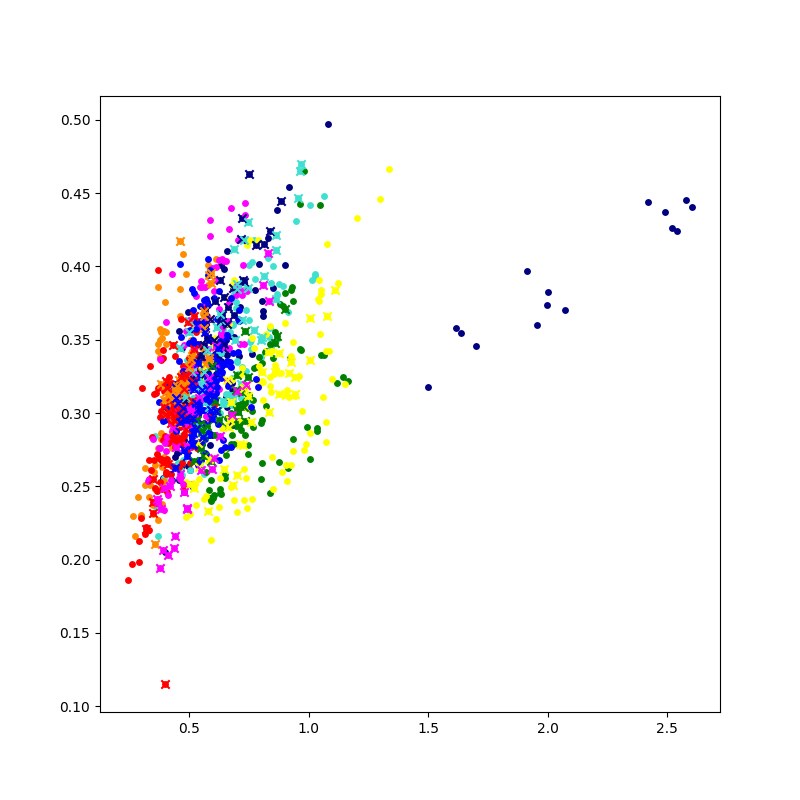

In [5]:
data = np.array(dataset)
target_names = ['c-CS-s','c-CS-m','c-SC-s','c-SC-m','t-CS-s','t-CS-m','t-SC-s','t-SC-m']


skf = StratifiedKFold(n_splits=4)
train_index, test_index = next(iter(skf.split(data[:,1:-4], data[:,-1])))

features = data[:,1:-4]
labels = data[:,-1]

X = features
y = labels
X_train = features[train_index]
y_train = labels[train_index]
X_test = features[test_index]
y_test = labels[test_index]


n_classes = len(np.unique(y_train))
plt.figure(figsize=(8,8))
for n, color in zip(target_names,colors):
    data = features[labels == n]
    plt.scatter(data[:, 0], data[:, 1], s=15.5, color=color)
for n, color in zip(target_names,colors):
    data = X_test[y_test == n]
    plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)
plt.show()

&nbsp;

Пополнување на средна вредност (mean) на вредности што недостасуваат

In [6]:
imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean')
imp_mean.fit(X)
SimpleImputer()
X2=imp_mean.transform(X)

&nbsp;

## PCA

In [7]:
pca = PCA(n_components=2) 
X_PCA = pca.fit(X2).transform(X2)  

In [8]:
X_PCA_train, X_PCA_test, y_PCA_train, y_PCA_test = train_test_split(X_PCA, y, test_size=0.30) 

<IPython.core.display.Javascript object>


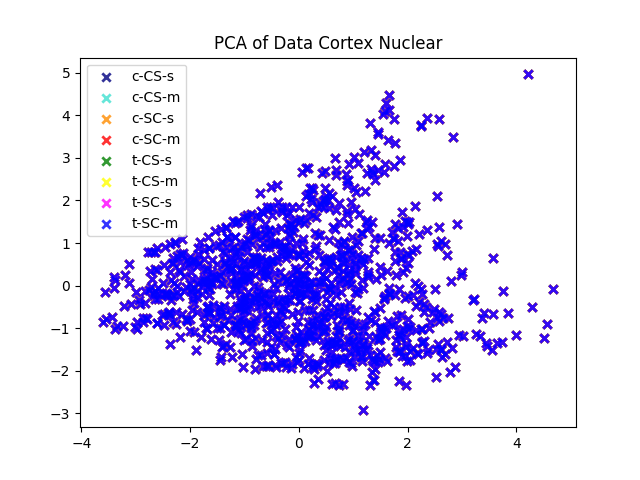

In [9]:
plt.figure() 
for color, i, target_name in zip(colors, target_names,target_names):
    plt.scatter(X_PCA[:, 0], X_PCA[:, 1], marker='x', color=color, alpha=.8, lw=2,label=target_name)
plt.legend(loc='best', shadow=False, scatterpoints=1)
plt.title('PCA of Data Cortex Nuclear')
plt.show()

In [10]:
pca_3d = PCA(n_components = 3)
pca_3d.fit(X2)

data_pca_3d = pca_3d.transform(X2)

<IPython.core.display.Javascript object>


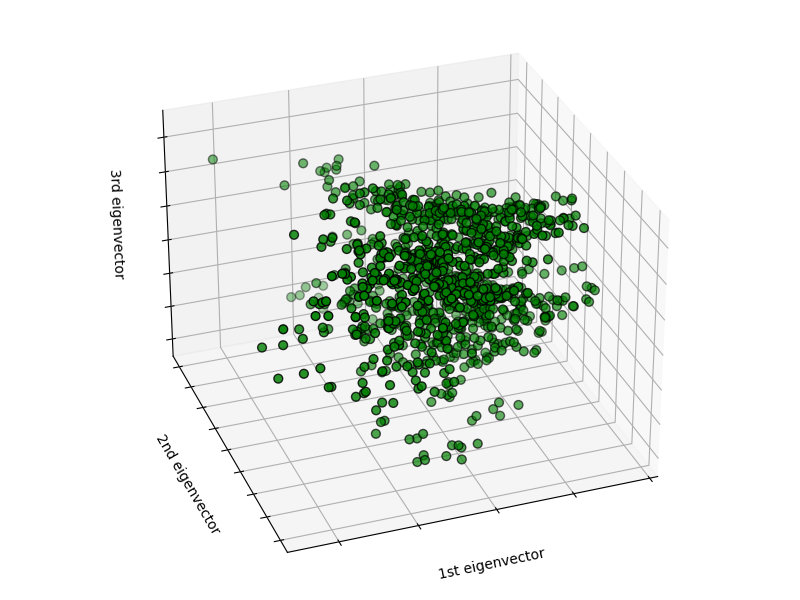

In [11]:
fig = plt.figure(figsize=(8, 6))
ax = Axes3D(fig, elev=-150, azim=110)

ax.scatter(data_pca_3d[:, 0], data_pca_3d[:, 1], data_pca_3d[:, 2], c='green', edgecolor='k', s=40)
ax.set_title("First three PCA directions")
ax.set_xlabel("1st eigenvector")
ax.set_ylabel("2nd eigenvector")
ax.set_zlabel("3rd eigenvector")
ax.w_xaxis.set_ticklabels([])
ax.w_yaxis.set_ticklabels([])
ax.w_zaxis.set_ticklabels([])
plt.show()

&nbsp;

## Gaussian Mixture Models
Веројатносен модел кој претпоставува дека сите точки на податоци се генерирани од мешавина на конечен број Гаусови распределби со непознати параметри.

<IPython.core.display.Javascript object>


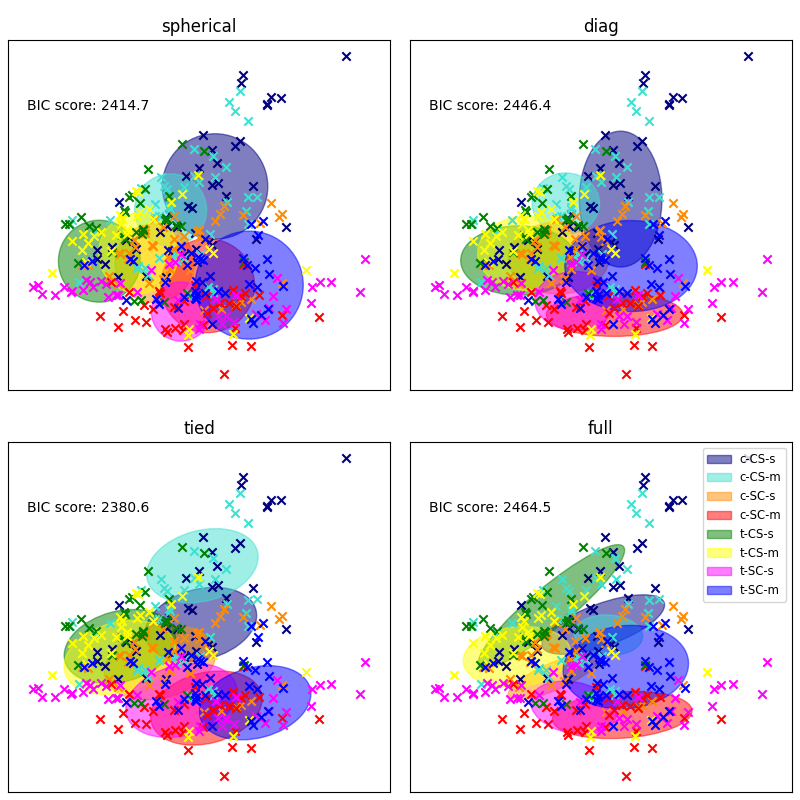

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


In [12]:
estimators = {cov_type: GaussianMixture(n_components=8,
              covariance_type=cov_type, max_iter=20, random_state=0)
              for cov_type in ['spherical', 'diag', 'tied', 'full']}

n_estimators = len(estimators)

plt.figure(figsize=(4 * n_estimators // 2, 8))
plt.subplots_adjust(bottom=.01, top=0.95, hspace=.15, wspace=.05,
                    left=.01, right=.99)

for index, (name, estimator) in enumerate(estimators.items()):
    estimator.means_init = np.array([X_PCA_train[y_PCA_train == i].mean(axis=0)
                                    for i in target_names])
    
    estimator.fit(X_PCA_train)

    h = plt.subplot(2, n_estimators // 2, index + 1)
    make_ellipses(estimator, h)

    
    # Plot the test data with crosses
    for n, color in zip(target_names,colors):
        data = X_PCA_test[y_PCA_test == n]
        plt.scatter(data[:, 0], data[:, 1], marker='x', color=color)


    plt.text(0.05, 0.8, 'BIC score: %.1f' % estimator.bic(X_PCA_test),
             transform=h.transAxes)
    plt.xticks(())
    plt.yticks(())
    plt.title(name)

plt.legend(scatterpoints=1, loc='lower right', prop=dict(size=12))
plt.legend(['c-CS-s','c-CS-m','c-SC-s','c-SC-m','t-CS-s','t-CS-m','t-SC-s','t-SC-m'], fontsize = 'small')
plt.show()

&nbsp;

## K-means
Метод на векторска квантизација, првично од обработка на сигналот, кој има за цел да подели n набљудувања во k кластери во кое секое набљудување припаѓа на кластерот со најблиската средина (центри на кластери или центроиди на кластери), служејќи како прототип на кластерот

#### init='random'

<IPython.core.display.Javascript object>


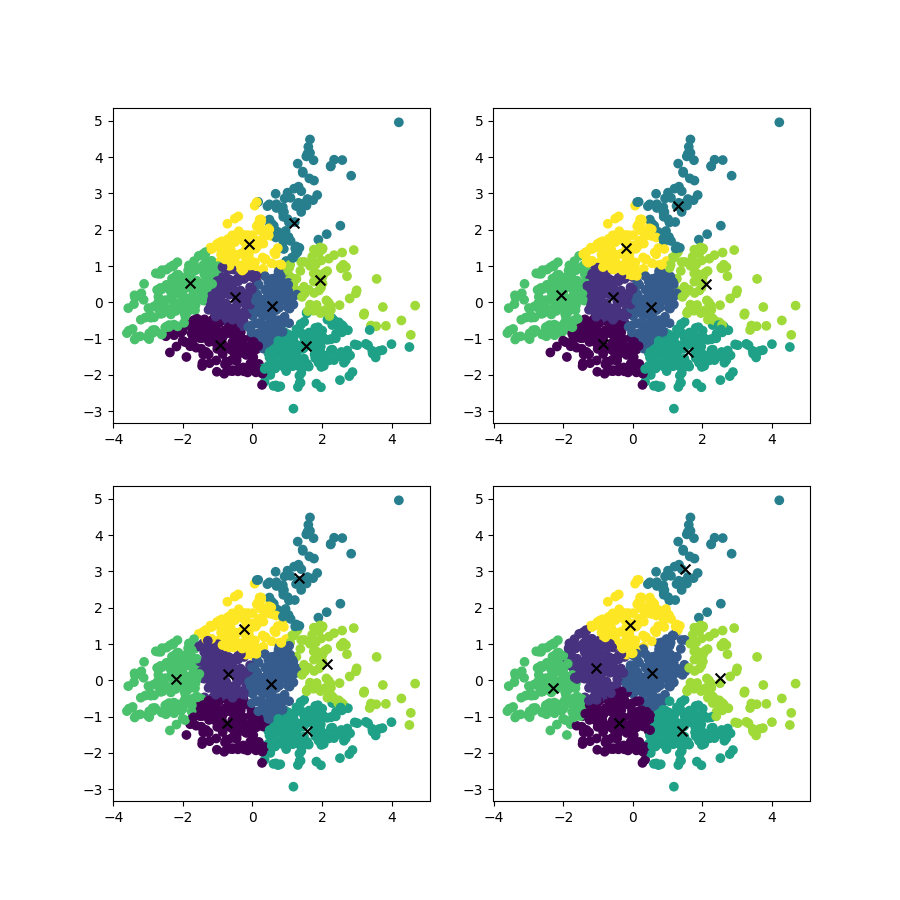

In [13]:
n_samples = 150
random_state = 180
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

iterations = [1,2,3,10]

fig2 = plt.figure(figsize=(9, 9))
plt.title("K-means iterations")
for i in range(len(iterations)):
    plt.subplot(2, 2, i+1)
    estimator = KMeans(init='random', n_clusters=8, random_state=170, n_init=1, max_iter=iterations[i])
    y_pred = estimator.fit_predict(X_PCA) 

    plt.scatter(X_PCA[:, 0], X_PCA[:, 1], c=y_pred)
    plt.scatter(estimator.cluster_centers_[:,0],estimator.cluster_centers_[:,1], s=50, marker='x', color="black")

#### init='k-means++'

<IPython.core.display.Javascript object>


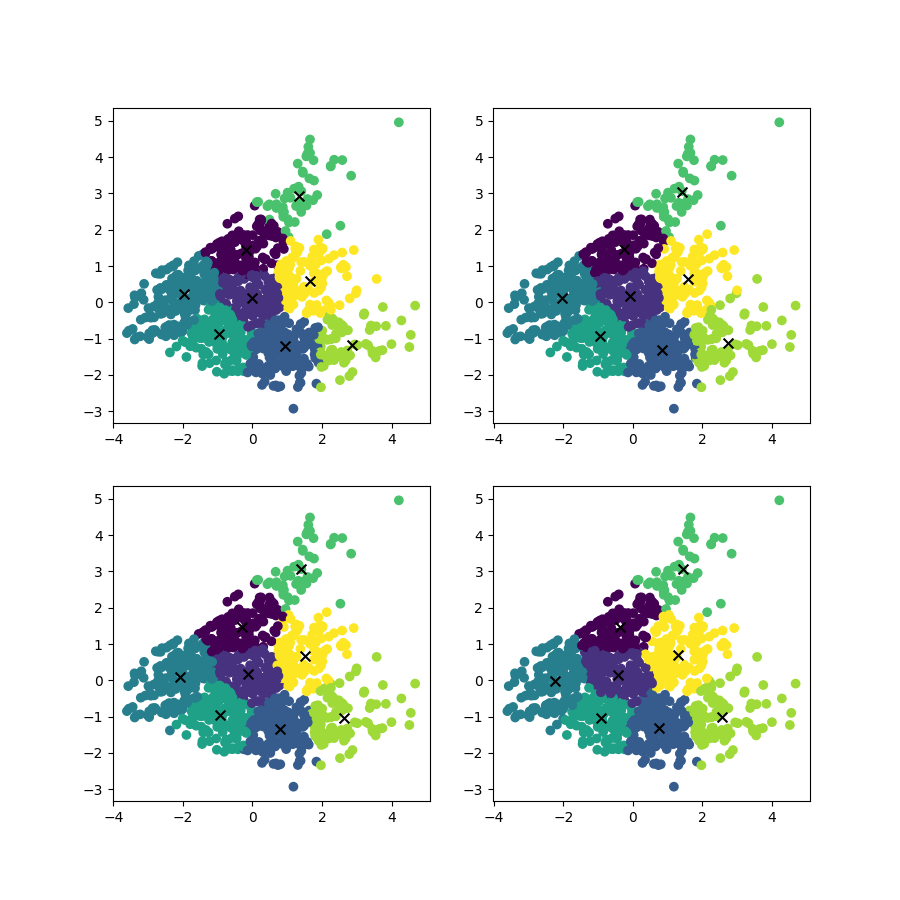

In [14]:
n_samples = 150
random_state = 180
X, y = make_blobs(n_samples=n_samples, random_state=random_state)

iterations = [1,2,3,10]

fig2 = plt.figure(figsize=(9, 9))
plt.title("K-means iterations")
for i in range(len(iterations)):
    plt.subplot(2, 2, i+1)
    estimator = KMeans(init='k-means++', n_clusters=8, random_state=170, n_init=1, max_iter=iterations[i])
    y_pred = estimator.fit_predict(X_PCA) 

    plt.scatter(X_PCA[:, 0], X_PCA[:, 1], c=y_pred)
    plt.scatter(estimator.cluster_centers_[:,0],estimator.cluster_centers_[:,1], s=50, marker='x', color="black")

&nbsp;

## Agglomerative Clustering
Најчестиот тип на хиерархиско кластерирање што се користи за групирање објекти во кластери врз основа на нивната сличност

#### Ward linkage

In [15]:
cluster = AgglomerativeClustering(n_clusters=8, affinity='euclidean', linkage='ward')
cluster.fit_predict(X_PCA)

array([1, 1, 1, ..., 5, 5, 5], dtype=int64)

<IPython.core.display.Javascript object>


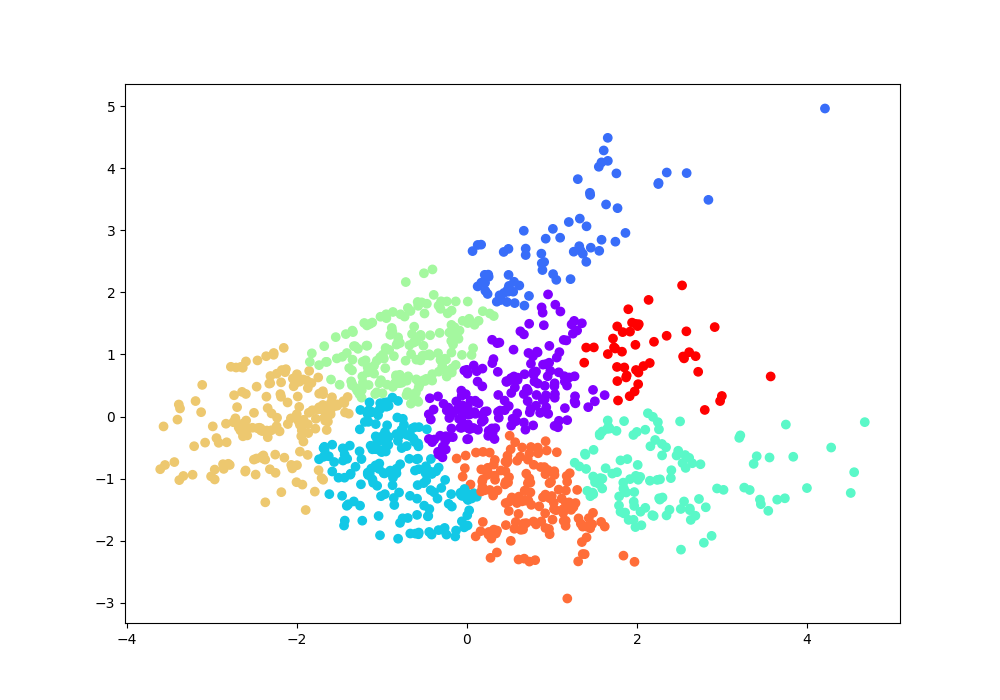

In [16]:
plt.figure(figsize=(10, 7))
plt.scatter(X_PCA[:,0], X_PCA[:,1], c=cluster.labels_, cmap='rainbow')

<IPython.core.display.Javascript object>


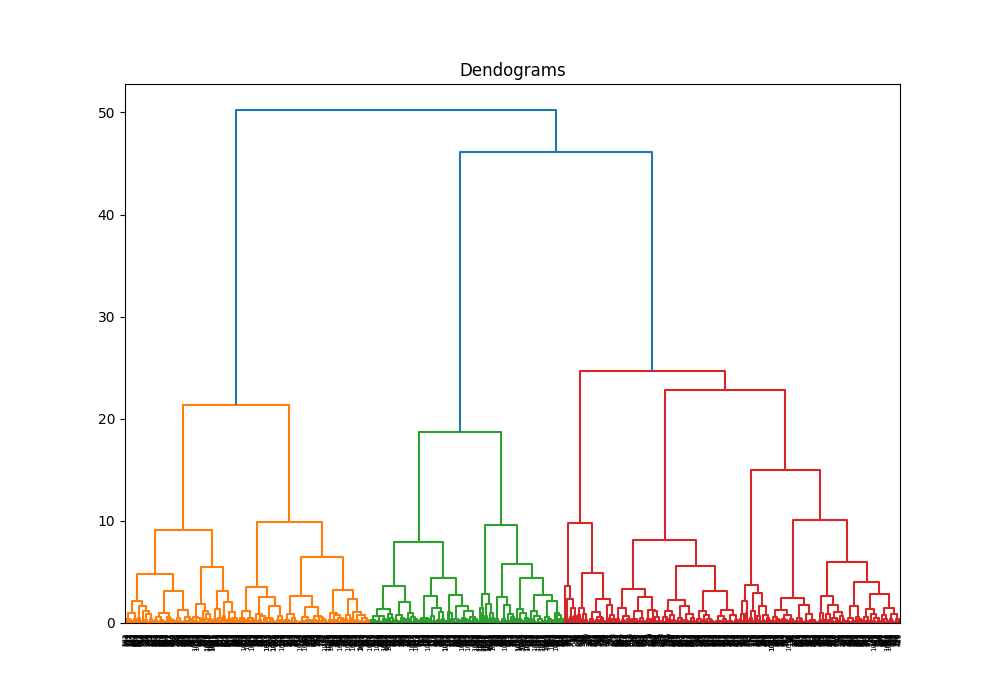

In [17]:
plt.figure(figsize=(10, 7))
plt.title("Dendograms")
dend = shc.dendrogram(shc.linkage(X_PCA, method='ward'))

#### Single linkage

In [18]:
cluster2 = AgglomerativeClustering(n_clusters=8, affinity='euclidean', linkage='single')
cluster2.fit_predict(X_PCA)

array([0, 0, 0, ..., 0, 0, 0], dtype=int64)

<IPython.core.display.Javascript object>


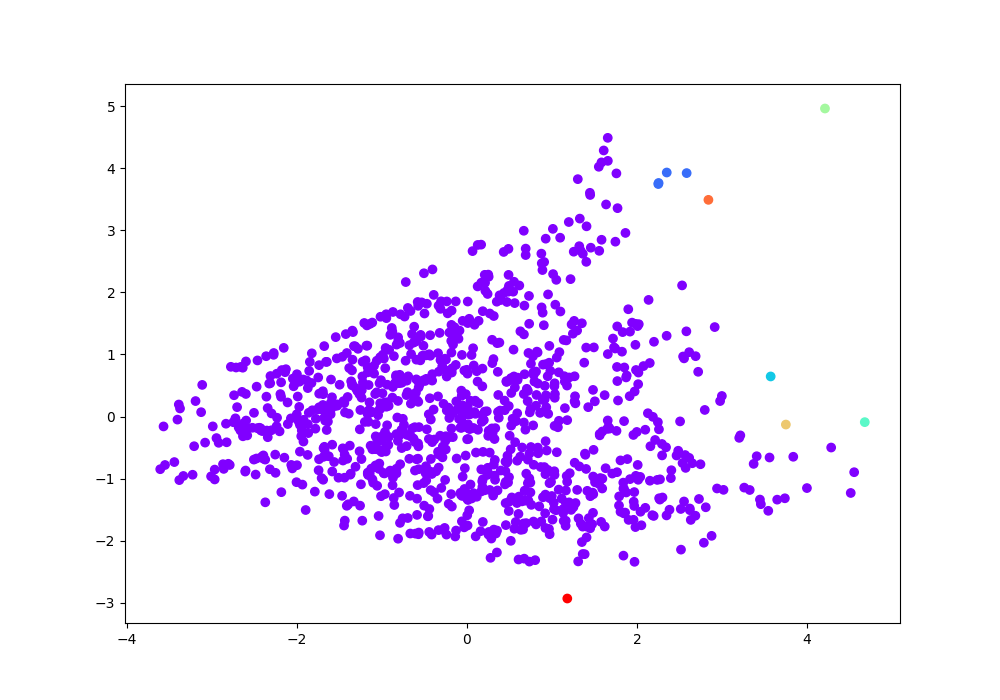

In [19]:
plt.figure(figsize=(10, 7))
plt.scatter(X_PCA[:,0], X_PCA[:,1], c=cluster2.labels_, cmap='rainbow')

<IPython.core.display.Javascript object>


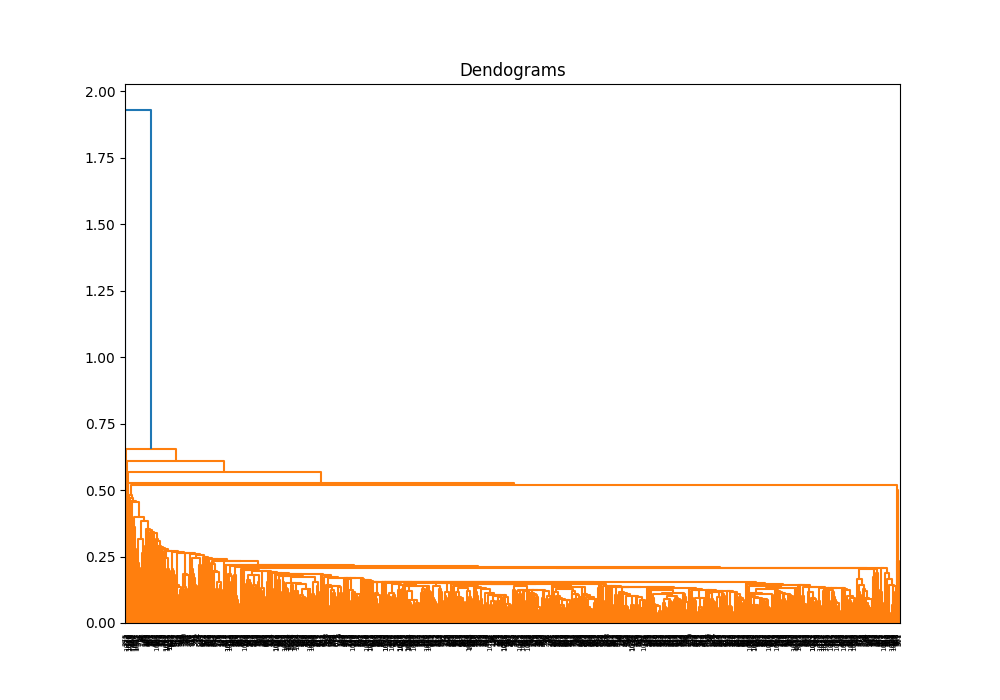

In [20]:
plt.figure(figsize=(10, 7))
plt.title("Dendograms")
dend = shc.dendrogram(shc.linkage(X_PCA, method='single'))

#### Complete linkage

In [21]:
cluster3 = AgglomerativeClustering(n_clusters=8, affinity='euclidean', linkage='complete')
cluster3.fit_predict(X_PCA)

array([4, 3, 3, ..., 1, 1, 1], dtype=int64)

<IPython.core.display.Javascript object>


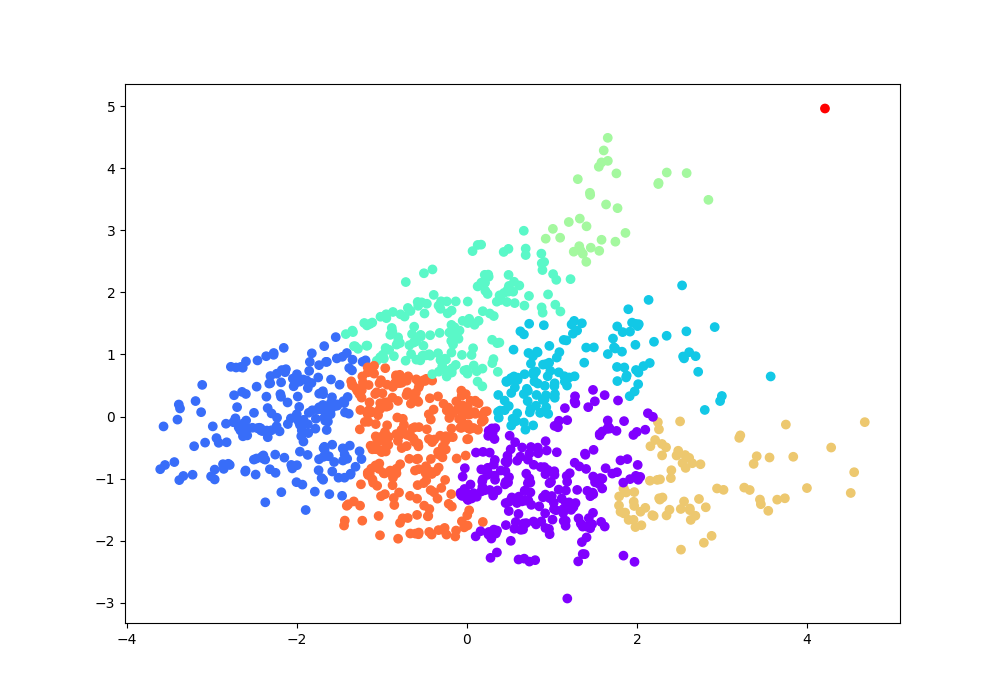

In [22]:
plt.figure(figsize=(10, 7))
plt.scatter(X_PCA[:,0], X_PCA[:,1], c=cluster3.labels_, cmap='rainbow')

<IPython.core.display.Javascript object>


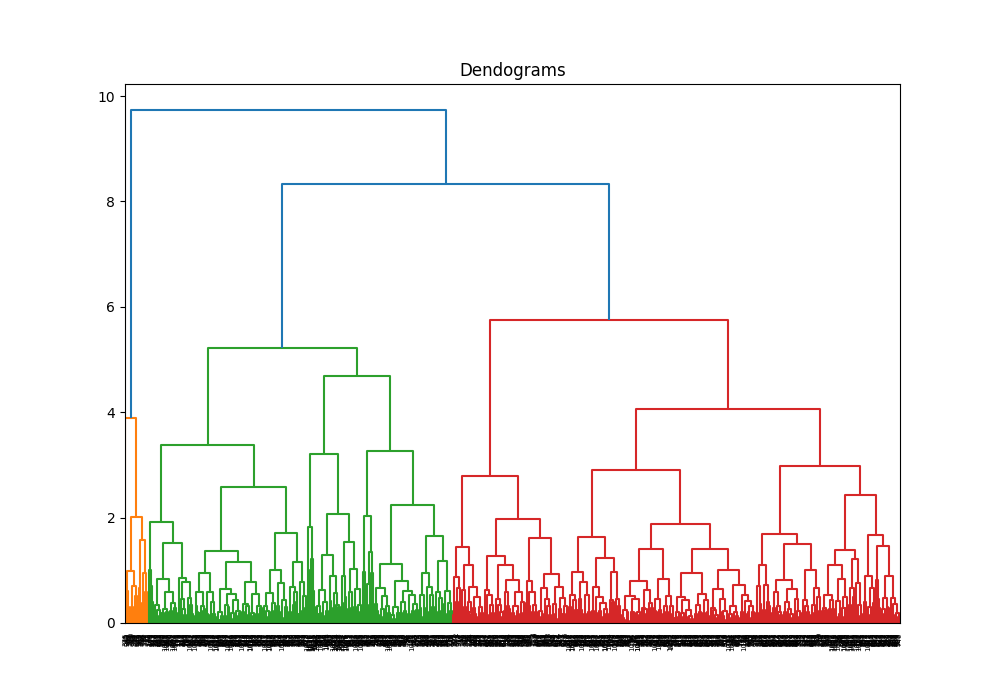

In [23]:
plt.figure(figsize=(10, 7))
plt.title("Dendograms")
dend = shc.dendrogram(shc.linkage(X_PCA, method='complete'))

#### Average linkage

In [24]:
cluster4 = AgglomerativeClustering(n_clusters=8, affinity='euclidean', linkage='average')
cluster4.fit_predict(X_PCA)

array([3, 3, 3, ..., 0, 0, 0], dtype=int64)

<IPython.core.display.Javascript object>


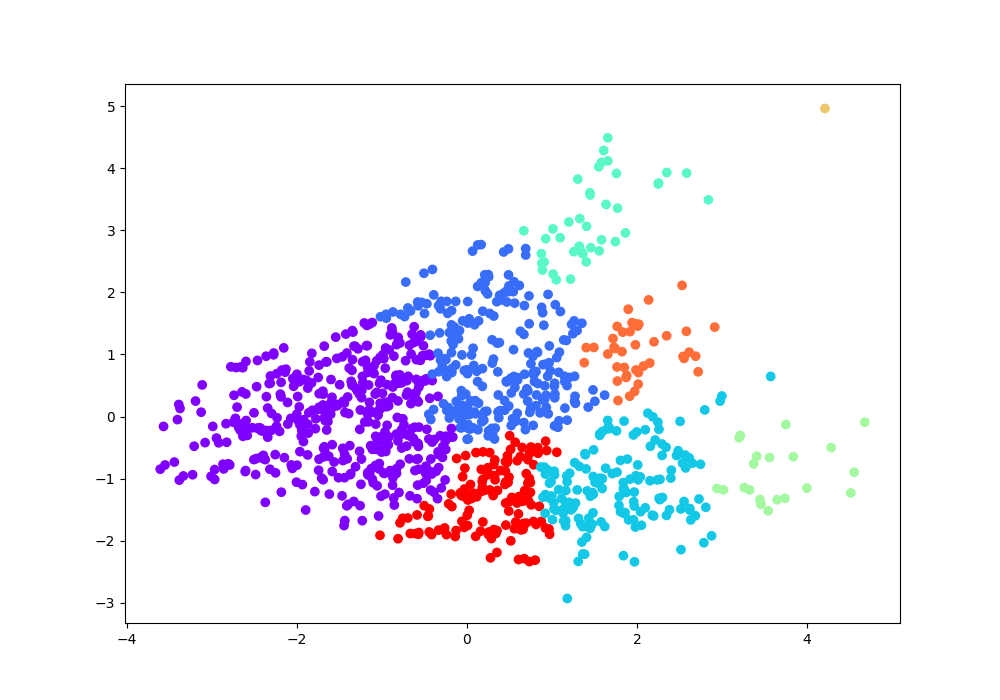

In [25]:
plt.figure(figsize=(10, 7))
plt.scatter(X_PCA[:,0], X_PCA[:,1], c=cluster4.labels_, cmap='rainbow')

<IPython.core.display.Javascript object>


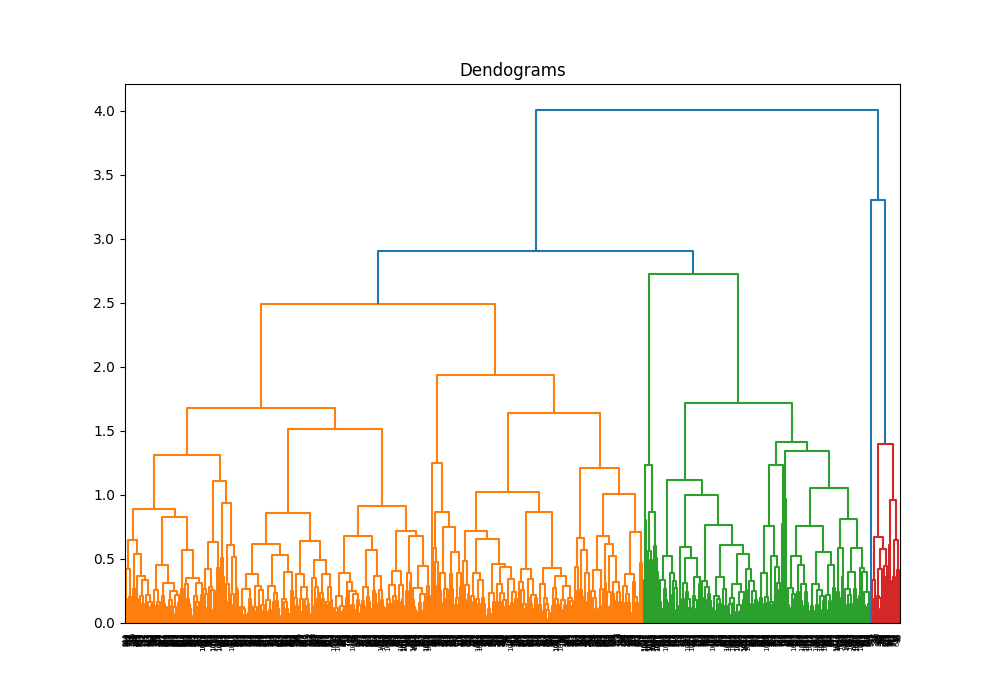

In [26]:
plt.figure(figsize=(10, 7))
plt.title("Dendograms")
dend = shc.dendrogram(shc.linkage(X_PCA, method='average'))

&nbsp;

## DBSCAN (Density-Based Spatial Clustering of Applications with Noise)
Открива кластери со различни форми и големини од голема количина на податоци, кои содржат шум и оддалеченост.

<IPython.core.display.Javascript object>


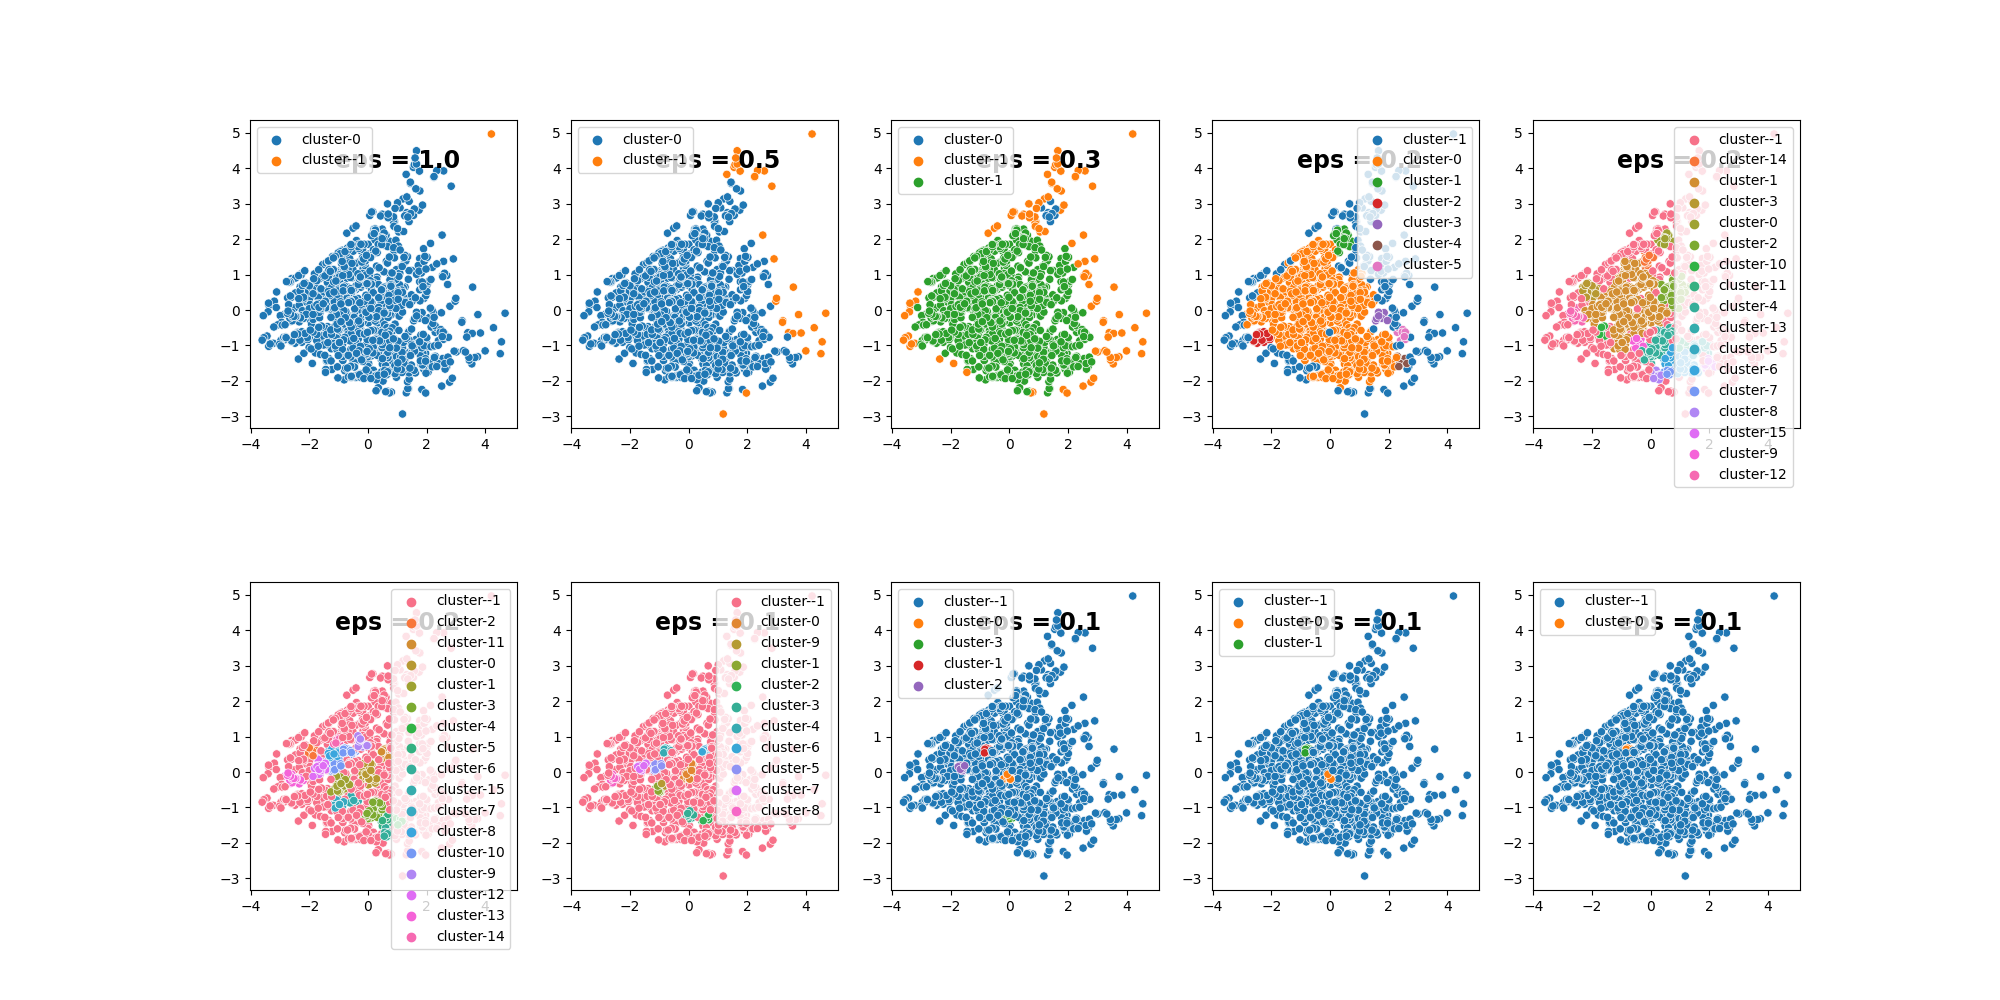

1.0
0.5
0.3333333333333333
0.25
0.2
0.16666666666666666
0.14285714285714285
0.125
0.1111111111111111
0.1


In [27]:
fig = plt.figure(figsize=(20, 10))
fig.subplots_adjust(hspace=.5, wspace=.2)
i = 1
for x in range(10, 0, -1):
    eps = 1/(11-x)
    db = DBSCAN(eps=eps, min_samples=10).fit(X_PCA)
    core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
    core_samples_mask[db.core_sample_indices_] = True
    labels = db.labels_
    
    print(eps)
    ax = fig.add_subplot(2, 5, i)
    ax.text(1, 4, "eps = {}".format(round(eps, 1)), fontsize=17, ha="center", fontweight = 'extra bold')
    sns.scatterplot(X_PCA[:,0], X_PCA[:,1], hue=["cluster-{}".format(x) for x in labels])
    
    i += 1